<img src='https://raw.githubusercontent.com/Deci-AI/super-gradients/master/docs/assets/SG_img/SG%20-%20Horizontal%20Glow.png'>

# You are now about to witness 🏎️YOLO-NAS!

### 👋🏽 What's up! It's [Harpreet](https://www.youtube.com/@Pyresearch/videos)


I'll be guiding you through this notebook. At any point, if you get stuck or have questions, there are two ways to get in touch:

1) Hop into the [Deep Learning Daily (powered by Deci) Discord server](https://discord.gg/p9ecgRhDR8), and let me know what your question is.

2) [Open an issue on GitHub](https://github.com/Deci-AI/super-gradients/issues/new/choose)

#### If you haven't already, be sure to go through the intro to SG notebook. You can find it [here.](https://bit.ly/yolo-nas-starter-notebook)



# 🔖 Read all the details in the technical blog

I won't go into the architecture here, but I encourage you to read [this technical blog](https://deci.ai/blog/YOLO-NAS-object-detection-foundation-model) if you're interested in details.

## 🥜 In a nutshell...

#### We used Neural Architecture Search to find the architecture. You can learn more about that [here](https://deci.ai/neural-architecture-search/)

- Neural Architecture Search (NAS) automates network architecture engineering

  - Consists of three components: search space, search strategy, performance estimation strategy

  - Our search space was inspired by YOLOv6, YOLOv8, and [QARepVGG blocks](https://arxiv.org/abs/2212.01593). 
 
#### Quantization aware architecture.

  - Quantization is one of several optimization methods for reducing the size of neural networks while also achieving high-performance accuracy.
  - Quantization is the process of substituting floating-point weights and/or activations with low precision compact representations. 
  - Results in the a decrease of memory size and computational cost of using neural networks, which can be important for edge applications. 
  - Learn more about quantization [here](https://deci.ai/quantization-and-quantization-aware-training/).

- YOLO-NAS uses hybrid quantization method selectively quantizes parts of a model. This means some operators are quantized to INT8 precision, and some are left in mode representative data type like FP16 or FP32

### Pre-trained on MS COCO, Object365, and RoboFlow100 using semi-supervised learning approaches

- It's a foundation model for object detection

- Pre-training regimen includes automatically labeled data, self-distillation, and large datasets

- Ideal for real-world scenarios needing low latency and efficient processing

Sets new benchmark for object detection models in accuracy and latency tradeoffs

<img src='https://deci.ai/wp-content/uploads/2023/05/Efficient-Frontier-of-Object-Detection-on-COCO-Measured-on-NVIDIA-T4_1.png'>


# 👩🏿‍🔧 Installations

## Note: after installation is complete (it make take a few minutes), you'll need to restart the runtime after installation completes. 

This is a known [issue](https://github.com/noorkhokhar99/YOLO-NAS-Custom-Object-Detection-Dice-Detection-Using-YOLO-NAS) that is on our roadmap.

In [ ]:
#%%capture
#!pip install super-gradients==3.1.1
#!pip install roboflow

In [ ]:
!nvidia-smi

Sat May 13 18:48:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 🏗️ Imports

In [ ]:
import os
import pathlib
import random
import shutil
import requests
import torch
from PIL import Image
from pathlib import Path
from typing import Union, Dict, List
from sklearn.model_selection import train_test_split
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
import cv2
from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

from roboflow import Roboflow

%matplotlib inline

The console stream is logged into /root/sg_logs/console.log


[2023-05-13 18:48:18] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-05-13 18:48:29] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-13 18:48:29] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-13 18:48:29] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-13 18:48:29] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


# 🫣 Sneakpeak: Inference with YOLO-NAS

[2023-05-13 18:48:29] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


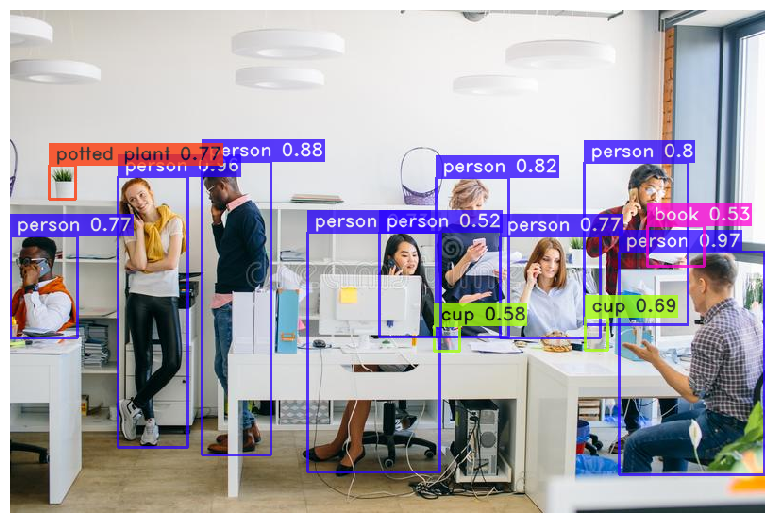

In [ ]:
url="https://thumbs.dreamstime.com/b/energetic-mixed-race-office-people-using-mobile-phones-work-working-people-their-gadgets-energetic-office-people-118751456.jpg"

yolo_nas_l = models.get("yolo_nas_s", pretrained_weights="coco")
yolo_nas_l.predict(url, conf=.50).show()

# 🏛️ Inspect the architecture

In [ ]:
!pip install torchinfo
from torchinfo import summary

summary(model=yolo_nas_l, 
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_S (YoloNAS_S)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

# 🧑🏽‍💻 Download dataset from RoboFlow

We'll use the [six-sided dice dataset](https://public.roboflow.com/object-detection/dice/2) from RoboFlow.

This is a small dataset of 359 images of mostly the same set of dice on a table.



In [ ]:

%%capture
rf = Roboflow(api_key="gW2iDUyfhIAgZs4xJWGJ")
project = rf.workspace("roboflow-gw7yv").project("dice")
dataset = project.version(2).download("yolov8")




In [ ]:
def split_data(data_dir, output_dir, test_ratio=0.15, val_ratio=0.15):
    # Create output directories
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    (output_dir/'train/images').mkdir(parents=True, exist_ok=True)
    (output_dir/'train/labels').mkdir(parents=True, exist_ok=True)
    (output_dir/'val/images').mkdir(parents=True, exist_ok=True)
    (output_dir/'val/labels').mkdir(parents=True, exist_ok=True)
    (output_dir/'test/images').mkdir(parents=True, exist_ok=True)
    (output_dir/'test/labels').mkdir(parents=True, exist_ok=True)

    # Separate images from annotations
    images = sorted(list((Path(data_dir)/'images').glob('*.jpg')))
    annotations = sorted(list((Path(data_dir)/'labels').glob('*.txt')))

    # Shuffle images and annotations in the same way
    zipped = list(zip(images, annotations))
    random.shuffle(zipped)
    images, annotations = zip(*zipped)

    # Split data into train + val and test
    train_images, test_images, train_annotations, test_annotations = train_test_split(
        images, annotations, test_size=test_ratio, random_state=1)

    # Split train data into train and val
    train_images, val_images, train_annotations, val_annotations = train_test_split(
        train_images, train_annotations, test_size=val_ratio / (1 - test_ratio), random_state=1)

    # Copy files
    for img, ann in zip(train_images, train_annotations):
        shutil.copy(img, output_dir/'train/images')
        shutil.copy(ann, output_dir/'train/labels')

    for img, ann in zip(val_images, val_annotations):
        shutil.copy(img, output_dir/'val/images')
        shutil.copy(ann, output_dir/'val/labels')

    for img, ann in zip(test_images, test_annotations):
        shutil.copy(img, output_dir/'test/images')
        shutil.copy(ann, output_dir/'test/labels')

# Usage
split_data('/content/Dice-2/export', 'split_data')

# 🗃️ Config

This class will store variables that will be used throughout the notebook

In [ ]:
class config:
    #trainer params
    EXPERIMENT_NAME = 'rolling-the-dice' #specify the experiment name
    CHECKPOINT_DIR = 'checkpoint' #specify the path you want to save checkpoints to

    #dataset params
    DATA_DIR = '/content/split_data' #parent directory to where data lives

    TRAIN_IMAGES_DIR = 'train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train/labels' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = 'val/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'val/labels' #child dir of DATA_DIR where validation labels are

    # if you have a test set
    TEST_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where test labels are

    CLASSES = ['1', '2', '3', '4', '5', '6'] #what class names do you have

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':32,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_s' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

# 🕵🏻 🗺️ Exploring the data 

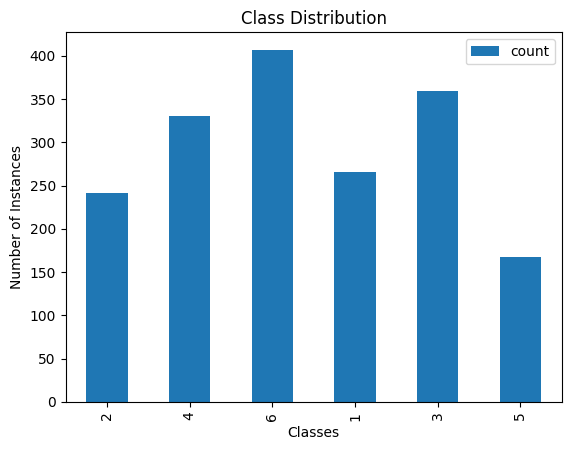

In [ ]:
data_dir = Path("/content/split_data")
images_dir = data_dir / "train" / "images"
labels_dir = data_dir / "train" / "labels"

class_names = config.CLASSES

# Read the image file paths and annotations
image_paths = list(images_dir.glob("*.jpg"))
label_paths = sorted(labels_dir.glob("*.txt"))



class_counts = Counter()
for label_file in label_paths:
    with open(label_file, "r") as file:
        lines = file.readlines()
    class_counts.update(Counter([int(line.split()[0]) for line in lines]))

# Replace class IDs with class names
class_counts_names = {class_names[int(class_id)]: count for class_id, count in class_counts.items()}

# Create a pandas DataFrame and plot the bar chart
df = pd.DataFrame.from_dict(class_counts_names, orient="index", columns=["count"])
ax = df.plot(kind="bar")
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution")
plt.show()

<Axes: >

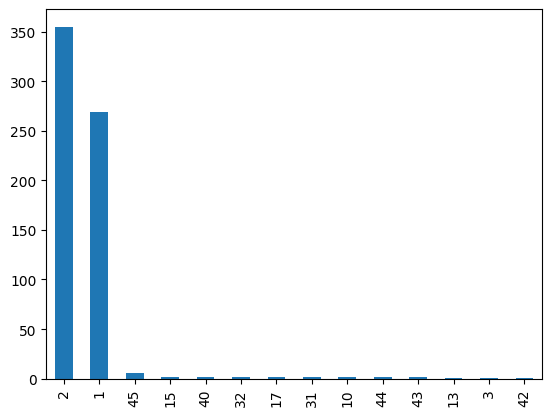

In [ ]:
data = []

for file in label_paths:
    with open(file) as f:
        lines = f.readlines()
        num_lines = len(lines)
        unique_values = len(set(list(map(lambda x: x.split()[0], lines))))
        
        data.append([file, num_lines, unique_values])

df = pd.DataFrame(data, columns=['file', 'num_lines', 'unique_values'])

# distribution of number of detections in an image
df['num_lines'].value_counts().plot(kind='bar')

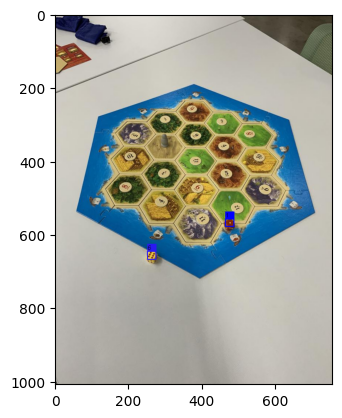

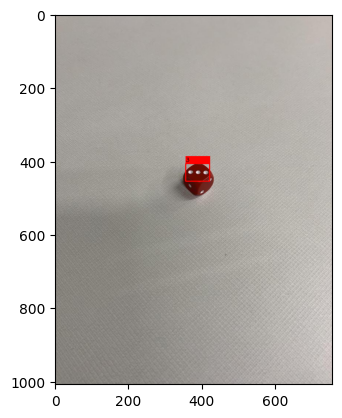

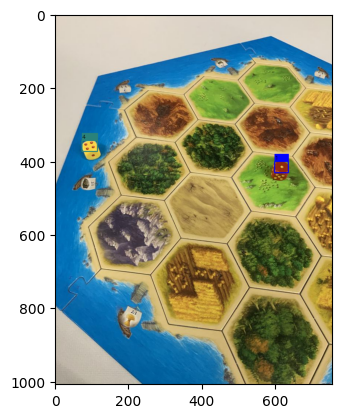

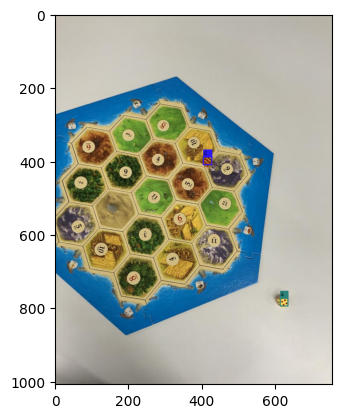

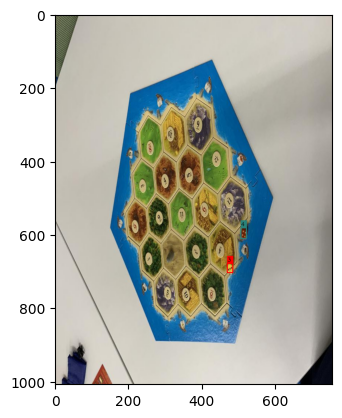

In [ ]:
# Number of images to randomly select
num_images = 5

# Get the list of all image files in the 'images' directory
image_files = [f for f in pathlib.Path(images_dir).iterdir() if f.is_file()]

# Shuffle the list of image files
random.shuffle(image_files)

# Select the specified number of image files
selected_image_files = image_files[:num_images]

for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    # Get the corresponding label file
    demo_label = pathlib.Path(labels_dir) / f"{selected_image_file.stem}.txt"

    # Load the image using OpenCV's imread function
    image = cv2.imread(str(demo_image))

    # Get the list of class names from the 'data' dictionary
    class_list = config.CLASSES

    # Define a list of colors to be used to draw bounding boxes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (122, 130, 42), (42, 142, 42), (242, 25, 42)]

    # Get the height and width of the image
    height, width, _ = image.shape

    # Create an empty list T
    T = []

    # Open the label file 'demo_label' in read mode and process each line
    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            # Split the line into a list of strings
            split = line.split(" ")

            # Get the class id from the first element of the split list
            class_id = int(split[0])

            # Get the color corresponding to the class id from the 'colors' list
            color = colors[class_id]
            clazz = class_list[class_id]

            # Get the x, y, w, h bounding box coordinates from the split list
            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

            # Rescale the x, y, w, h values to the size of the image
            box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]

            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)

            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

            # Write the class label on the image
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        image = cv2.resize(image, (600, 600))
        plt.show()

# 🏋🏽 The Trainer

In [ ]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

# 💾 Datasets and Dataloaders


In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Caching annotations: 100%|██████████| 206/206 [00:00<00:00, 1428.92it/s]


## 👀 See what some images look like after augmentations

Caching annotations: 100%|██████████| 195/195 [00:00<00:00, 1861.14it/s]


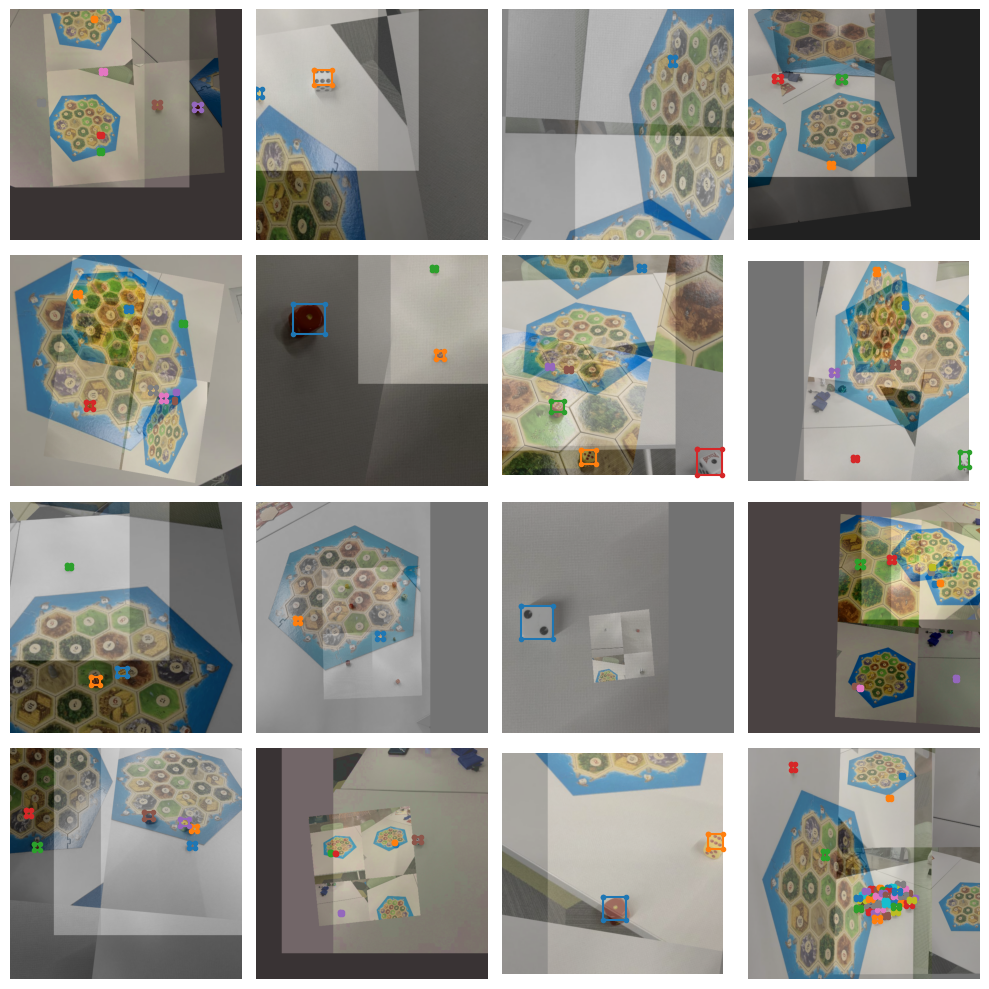

In [ ]:
train_data.dataset.plot()

# 👩🏽‍🦳 Instantiate the model

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial you're using `yolo_nas_s`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_m` and `yolo_nas_l`.

In [ ]:
model = models.get(config.MODEL_NAME, 
                   num_classes=config.NUM_CLASSES, 
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

[2023-05-13 18:49:10] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


# 📊 Define metrics and training parameters

You need to define the training parameters for your training run. 

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`. 

In [ ]:
train_params = {
    # ENABLING SILENT MODE
    "verbose":False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# 🦾 Train the model

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model 

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as..

In [ ]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2023-05-13 18:49:11] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoint/rolling-the-dice/console_May13_18_49_21.txt


[2023-05-13 18:49:33] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 649        (len(train_set))
    - Batch size per GPU:           32         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             32         (num_gpus * batch_size)
    - Effective Batch size:         32         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         20         (len(train_loader))
    - Gradient updates per epoch:   20         (len(train_loader) / batch_accumulate)

[2023-05-13 18:49:33] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Train epoch 0:  80%|████████  | 16/20 [01:01<00:15,  3.84s/it, PPYoloELoss/loss=4.77, PPYoloELoss/loss_cls=3.18, PPYoloELoss/loss_dfl=1.26, PPYoloELoss/loss_iou=0.385, gpu_mem=13]
[2023-05-13 18:50:34] INFO - base_sg_

OutOfMemoryError: ignored

# 🏆 Get the best trained model

Now that training is complete, you need to get the best trained model.

You used checkpoint averaging so the following code will use weights averaged across training runs. 

If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, ckpt_best.pth)`

- last weights: `checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, ckpt_latest.pth)`

In [ ]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

# 🧐 Evaluating the best trained model on the test set

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=config.NUM_CLASSES, 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              nms_threshold=0.7)
                                                  ))

# 🔮 Predicting with the best model

You can make a prediction by calling the `.predict()` method of the model object.

Note, you can set the confidence threshold value as you please.


In [ ]:
best_model.predict( "https://i.etsystatic.com/7970075/r/il/68741f/3838860973/il_fullxfull.3838860973_3n1o.jpg",  conf=0.45).show()

In [ ]:
best_model.predict( "https://ae01.alicdn.com/kf/S6ddb2c93922a40dc850c91c5b2abccfci/10PCS-Lot-Dice-Set-10-Colors-High-Quality-Solid-Acrylic-6-Sided-Dice-For-Club-Party.jpg_Q90.jpg_.webp",  conf=0.45).show()

# Post training quantization (PTQ) and quantization aware training (QAT)

SuperGradients offers PTQ and QAT out of the box. That's beyond the scope of this introductory tutorial. It is, in my opinion, a truly awesome feature. 

Not many training libaries offer this out of the box.  You can learn more about PTQ and QAT [here](https://github.com/Deci-AI/super-gradients/blob/c339e2619616878172c060e6491c8c2129ed3fd4/documentation/source/ptq_qat.md).

An example specific to YOLONAS can be found [here](https://github.com/Deci-AI/super-gradients/blob/feature/SG-736_deci_yolo_rf100/documentation/source/qat_ptq_yolo_nas.md).